In [0]:
########## (a) ##########
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Homework 4
# Copyright @ Johns Hopkins University, Cong Gao, cgao11@jhu.edu
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# IMPORTANT: This function is used for de-normalizing image to original domain,
# please use this if you want to visualize/recover your output result
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# These hyperparameters can be changed
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# This is a recommended normalization method. You can design your own
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

# Dataset wiill be downloaded to './data' folder
dataset = FashionMNIST('./data', transform=img_transform, download=True)
train_dataset = FashionMNIST('./data', train=True, transform=img_transform, download=True)
test_dataset = FashionMNIST('./data', train=False, transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

# This is our provided network autoencoder class, you are encouraged to change
# the structure settings
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
        # make sure you keep this layer during your autoencoder training, this
        # will be used for Q3-(c) fully connected layer
        self.linear = nn.Linear(32,10)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # IMPORTANT: in Q3-(c), please delete the above decoder layer, and use
        # the linear layer to build fully-connection layers.
        return x

In [4]:
########## (a) ##########
model = autoencoder()
if torch.cuda.is_available(): #use gpu if available
    model.cuda()

# In Q3-(c), you need to load your model using the following command
#model.load_state_dict(torch.load('./yourmodel.pth'))

# Setting requires_grad to False will 'freeze' the parameters during training
#model.encoder.requires_grad = False

# This is a recommended optimizer setting
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

criterion = nn.MSELoss()

# Training & Validation
for epoch in range(num_epochs):
    for data in dataloader:
        images = data[0]
        images = Variable(images.float())
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d" % (epoch+1))
    print("Training Loss: %.4f" % (loss.data.item()))

# # This is used to save your model, please remember to include it
torch.save(model.state_dict(), './yourmodel.pth')



Epoch: 1
Training Loss: 0.1142
Epoch: 2
Training Loss: 0.1048
Epoch: 3
Training Loss: 0.0835
Epoch: 4
Training Loss: 0.0928
Epoch: 5
Training Loss: 0.0888
Epoch: 6
Training Loss: 0.0796
Epoch: 7
Training Loss: 0.0843
Epoch: 8
Training Loss: 0.0810
Epoch: 9
Training Loss: 0.0754
Epoch: 10
Training Loss: 0.0707
Epoch: 11
Training Loss: 0.0717
Epoch: 12
Training Loss: 0.0760
Epoch: 13
Training Loss: 0.0770
Epoch: 14
Training Loss: 0.0711
Epoch: 15
Training Loss: 0.0804
Epoch: 16
Training Loss: 0.0679
Epoch: 17
Training Loss: 0.0649
Epoch: 18
Training Loss: 0.0677
Epoch: 19
Training Loss: 0.0741
Epoch: 20
Training Loss: 0.0710


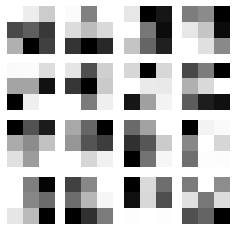

In [5]:
########## (a) ##########
### Feature Map
import matplotlib.pyplot as plt

kernel = model.encoder[0].weight.data.numpy()
figure = plt.figure(figsize=(4,4))
for i in range(len(kernel)):
    plot = figure.add_subplot(4,4, i+1)
    plot.imshow(kernel[i][0])
    plot.axis('off')
    plot.set_xticklabels([])
    plot.set_yticklabels([])

In [6]:
########## (b) ##########
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    iaa.Dropout(p=(0,0.2)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    iaa.SaltAndPepper(0.05)
])


model = autoencoder()
if torch.cuda.is_available(): #use gpu if available
    model.cuda()

# In Q3-(c), you need to load your model using the following command
#model.load_state_dict(torch.load('./yourmodel.pth'))

# Setting requires_grad to False will 'freeze' the parameters during training
#model.encoder.requires_grad = False

# This is a recommended optimizer setting
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

criterion = nn.MSELoss()

# Training & Validation
for epoch in range(num_epochs):
    for data in dataloader:
        images = data[0]
        images = Variable(images.float())
        ### Data Augmentation
        images_aug = seq.augment_images(images.numpy())
        
        optimizer.zero_grad()
        outputs = model(torch.Tensor(images_aug))

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d" % (epoch+1))
    print("Training Loss: %.4f" % (loss.data.item()))

# # This is used to save your model, please remember to include it
torch.save(model.state_dict(), './yourmodel_b.pth')

Epoch: 1
Training Loss: 0.3223
Epoch: 2
Training Loss: 0.2495
Epoch: 3
Training Loss: 0.2465
Epoch: 4
Training Loss: 0.2213
Epoch: 5
Training Loss: 0.2268
Epoch: 6
Training Loss: 0.2242
Epoch: 7
Training Loss: 0.2206
Epoch: 8
Training Loss: 0.2047
Epoch: 9
Training Loss: 0.1943
Epoch: 10
Training Loss: 0.1996
Epoch: 11
Training Loss: 0.2321
Epoch: 12
Training Loss: 0.1949
Epoch: 13
Training Loss: 0.2114
Epoch: 14
Training Loss: 0.2006
Epoch: 15
Training Loss: 0.1923
Epoch: 16
Training Loss: 0.1902
Epoch: 17
Training Loss: 0.1787
Epoch: 18
Training Loss: 0.2017
Epoch: 19
Training Loss: 0.1847
Epoch: 20
Training Loss: 0.2050


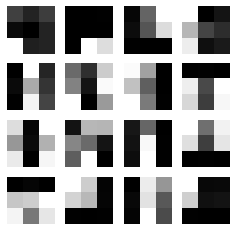

In [7]:
########## (b) ##########
### Feature Map
import matplotlib.pyplot as plt

kernel = model.encoder[0].weight.data.numpy()
figure = plt.figure(figsize=(4,4))
for i in range(len(kernel)):
    plot = figure.add_subplot(4,4, i+1)
    plot.imshow(kernel[i][0])
    plot.axis('off')
    plot.set_xticklabels([])
    plot.set_yticklabels([])

In [24]:
########## (c) ##########
# This is our provided network autoencoder class, you are encouraged to change
# the structure settings
class autoencoder3(nn.Module):
    def __init__(self):
        super(autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
        # make sure you keep this layer during your autoencoder training, this
        # will be used for Q3-(c) fully connected layer
        self.linear = nn.Linear(32,10)
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear(x)
        # IMPORTANT: in Q3-(c), please delete the above decoder layer, and use
        # the linear layer to build fully-connection layers.
        return x
      
model = autoencoder3()
if torch.cuda.is_available(): #use gpu if available
    model.cuda()

# In Q3-(c), you need to load your model using the following command
model.load_state_dict(torch.load('./yourmodel_b.pth'))

# Setting requires_grad to False will 'freeze' the parameters during training
model.encoder.requires_grad = False

# This is a recommended optimizer setting
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

# Training & Validation
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d" % (epoch+1))
    print("Training Loss: %.4f" % (loss.data.item()))


Epoch: 1
Training Loss: 0.8335
Epoch: 2
Training Loss: 1.0818
Epoch: 3
Training Loss: 0.5929
Epoch: 4
Training Loss: 0.5515
Epoch: 5
Training Loss: 0.6359
Epoch: 6
Training Loss: 0.6711
Epoch: 7
Training Loss: 0.5057
Epoch: 8
Training Loss: 0.5901
Epoch: 9
Training Loss: 0.5445
Epoch: 10
Training Loss: 0.6924
Epoch: 11
Training Loss: 0.5711
Epoch: 12
Training Loss: 0.4626
Epoch: 13
Training Loss: 0.4852
Epoch: 14
Training Loss: 0.4032
Epoch: 15
Training Loss: 0.3767
Epoch: 16
Training Loss: 0.6782
Epoch: 17
Training Loss: 0.6788
Epoch: 18
Training Loss: 0.4345
Epoch: 19
Training Loss: 0.5275
Epoch: 20
Training Loss: 0.4503
Epoch: 21
Training Loss: 0.5663
Epoch: 22
Training Loss: 0.4657
Epoch: 23
Training Loss: 0.3364
Epoch: 24
Training Loss: 0.4288
Epoch: 25
Training Loss: 0.4713
Epoch: 26
Training Loss: 0.5590
Epoch: 27
Training Loss: 0.4061
Epoch: 28
Training Loss: 0.4663
Epoch: 29
Training Loss: 0.5313
Epoch: 30
Training Loss: 0.5150
Epoch: 31
Training Loss: 0.4189
Epoch: 32
Trainin

In [25]:
########## (c) ##########
model.eval()
test_correct = 0
test_num = 0
for (images, labels) in test_loader:
    images = Variable(images.float())
    outputs = model(images)
    a, predicted = torch.max(outputs.data, 1)
    test_num += len(labels)
    test_correct += (predicted == labels).sum().item()
print("Test Accuracy is: " + str(test_correct/float(test_num)*100) + "%")

Test Accuracy is: 84.86%
